<a href="https://colab.research.google.com/github/pareshrchaudhary/colab/blob/main/QLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
import jax
import jax.numpy as jnp
import numpy as np
from jax.typing import ArrayLike
from jax import grad, vmap, jit
import matplotlib.pyplot as plt
import random

(65, 3)


Text(0.5, 1.0, 'Target Trajectory (x,y)')

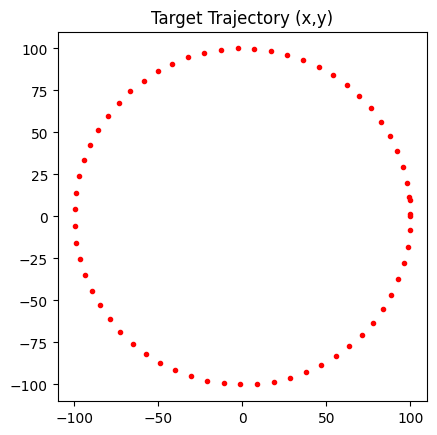

In [56]:
NTRAJSTEPS = 65 # no gap for dt = 0.1
dt = 0.1

target = jnp.zeros((NTRAJSTEPS, 3))
targtrajarray = jnp.arange(0.0, NTRAJSTEPS*dt, dt)

# Circle: compute positions
x = 100 * jnp.cos(targtrajarray)
y = 100 * jnp.sin(targtrajarray)

# Compute headings from positions
prevpos = jnp.column_stack((x[:-2], y[:-2]))
nextpos = jnp.column_stack((x[2:], y[2:]))
heading = nextpos - prevpos
theta = jnp.arctan2(heading[:, 1], heading[:, 0])

# Add heading for first and last position
theta = jnp.concatenate((jnp.array([jnp.arctan2(y[1] - y[0], x[1] - x[0])]), theta, jnp.array([jnp.arctan2(y[-1] - y[-2], x[-1] - x[-2])])))

target = jnp.column_stack((x, y, theta))
print(target.shape)
plt.figure()
plt.plot(target[:, 0], target[:, 1],'r.')
plt.axis('square')
plt.title('Target Trajectory (x,y)')

In [54]:
## DO NOT ALTER ##
rad2deg = 180.0 / np.pi
deg2rad = np.pi / 180.0
dt = 0.02

In [55]:
@jit
def car_dynamics(state, action, dt):
  L = 1
  x, y, theta = state
  velocity, delta = action

  xnew = x + jnp.cos(theta)*velocity*dt
  ynew = y + jnp.sin(theta)*velocity*dt
  thetanew = theta + (velocity/L) * jnp.tan(delta) * dt
  thetanew = jnp.mod(thetanew,2.0*jnp.pi)
  return jnp.array([xnew,ynew,thetanew]) # new state

@jit
def findnearest(target, current):
  lookahead = 2
  x, y, theta = current

  inter_x = (target[:-lookahead-1, 0] - x)**2
  inter_y = (target[:-lookahead-1, 1] - y)**2
  dist = jnp.sqrt(inter_x + inter_y)
  minindex = jnp.argmin(dist)
  return minindex  # index of minimum distance

@jit
def deviation(mi, target, current):
  x, y, theta = current
  nearest_trajectory = jnp.stack((target[mi, 0] - x, target[mi, 1] - y), axis=0)

  car_xvec = jnp.cos((jnp.pi/2.0) + theta)
  car_yvec = jnp.sin((jnp.pi/2.0) + theta)
  carLeftvec = jnp.stack((car_xvec, car_yvec), axis=0)

  error = -jnp.dot(nearest_trajectory, carLeftvec)
  return error

@jit
def reward_function(state, target):
    nearest_index = findnearest(target, state)

    deviation_error = deviation(nearest_index, target, state)

    if deviation_error >= 0:
        reward = 1.0  
    else:
        reward = -1.0  

    # Optionally, you can include additional reward components based on other factors
    # such as smoothness, collision avoidance, or time efficiency

    return reward

In [ ]:
from collections import deque

class ReplayBuffer:
    def __init__(self, buffer_size):
        self.buffer_size = buffer_size
        self.buffer = deque(maxlen=buffer_size)

    def add_experience(self, state, action, reward, next_state, done):
        experience = (state, action, reward, next_state, done)
        self.buffer.append(experience)

    def sample_batch(self, batch_size):
        batch = random.sample(self.buffer, batch_size)

        states = []
        actions = []
        rewards = []
        next_states = []
        dones = []

        for experience in batch:
            state, action, reward, next_state, done = experience
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            next_states.append(next_state)
            dones.append(done)

        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.buffer)
